In [319]:
# Importing the Necessary Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,ExtraTreesClassifier,AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from hyperopt import hp,fmin,tpe,STATUS_OK,Trials
from tpot import TPOTClassifier
from sklearn import metrics
import pickle
import joblib

In [320]:
#Applying load_data function and checking first five rows of the data
df=pd.read_csv('loan.csv',low_memory=False)

In [321]:
# Checking the information of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Columns: 111 entries, id to total_il_high_credit_limit
dtypes: float64(74), int64(13), object(24)
memory usage: 33.6+ MB


In [322]:
#Checking the shape of the dataset
df.shape

(39717, 111)

In [323]:
#Making a copy of the original dataframe
df1=df.copy()

In [324]:
#In this approach we are dropping the missing values 
df1.dropna(axis=1,how='any',inplace=True)

In [325]:
#Checking the unique dtypes of the dataset
pd.unique(df1.dtypes)

array([dtype('int64'), dtype('float64'), dtype('O')], dtype=object)

In [326]:
#Seperating the Numerical dtypes and categorical so as to analysis them properly because there
# a lot of features so to make our life easier
df_numeric=df1.select_dtypes(include=['int64','float64'])

In [327]:
df_numeric.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,...,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,policy_code,acc_now_delinq,delinq_amnt
0,1077501,1296599,5000,5000,4975.0,162.87,24000.0,27.65,0,1,...,5833.84,5000.00,863.16,0.00,0.00,0.00,171.62,1,0,0
1,1077430,1314167,2500,2500,2500.0,59.83,30000.0,1.00,0,5,...,1008.71,456.46,435.17,0.00,117.08,1.11,119.66,1,0,0
2,1077175,1313524,2400,2400,2400.0,84.33,12252.0,8.72,0,2,...,3005.67,2400.00,605.67,0.00,0.00,0.00,649.91,1,0,0
3,1076863,1277178,10000,10000,10000.0,339.31,49200.0,20.00,0,1,...,12231.89,10000.00,2214.92,16.97,0.00,0.00,357.48,1,0,0
4,1075358,1311748,3000,3000,3000.0,67.79,80000.0,17.94,0,0,...,3513.33,2475.94,1037.39,0.00,0.00,0.00,67.79,1,0,0


In [328]:
#Categorical features into seperate dataframe
df_categorical=df1.select_dtypes(include='O')

In [329]:
# Checking if it is applied correctly or not
df_categorical.head()

,term,int_rate,grade,sub_grade,home_ownership,verification_status,issue_d,loan_status,pymnt_plan,url,purpose,zip_code,addr_state,earliest_cr_line,initial_list_status,application_type
0,36 months,10.65%,B,B2,RENT,Verified,Dec-11,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,credit_card,860xx,AZ,Jan-85,f,INDIVIDUAL
1,60 months,15.27%,C,C4,RENT,Source Verified,Dec-11,Charged Off,n,https://lendingclub.com/browse/loanDetail.acti...,car,309xx,GA,Apr-99,f,INDIVIDUAL
2,36 months,15.96%,C,C5,RENT,Not Verified,Dec-11,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,small_business,606xx,IL,Nov-01,f,INDIVIDUAL
3,36 months,13.49%,C,C1,RENT,Source Verified,Dec-11,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,other,917xx,CA,Feb-96,f,INDIVIDUAL
4,60 months,12.69%,B,B5,RENT,Source Verified,Dec-11,Current,n,https://lendingclub.com/browse/loanDetail.acti...,other,972xx,OR,Jan-96,f,INDIVIDUAL


In [330]:
#Checking the value_counts of the target variable and we can clearly see that there is class imbalance 
#between them 
df_categorical['loan_status'].value_counts()

Fully Paid     32950
Charged Off     5627
Current         1140
Name: loan_status, dtype: int64

In [331]:
# Checking the first five rows of the target variable
df_categorical['loan_status'].head()

0     Fully Paid
1    Charged Off
2     Fully Paid
3     Fully Paid
4        Current
Name: loan_status, dtype: object

In [332]:
# So In the context of this case study we need only Fully Paid and Charged Off Loan Status therefore
#I need to filter the two columns from it and leave the Current using this technique
df_categorical=df_categorical[df_categorical['loan_status']!='Current']

In [333]:
# Filter out the Fully Paid Loan_Status
df_categorical[df_categorical['loan_status']=='Fully Paid'].head(1)

,term,int_rate,grade,sub_grade,home_ownership,verification_status,issue_d,loan_status,pymnt_plan,url,purpose,zip_code,addr_state,earliest_cr_line,initial_list_status,application_type
0,36 months,10.65%,B,B2,RENT,Verified,Dec-11,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,credit_card,860xx,AZ,Jan-85,f,INDIVIDUAL


In [334]:
df_categorical[df_categorical['loan_status']=='Charged Off'].head(1)

,term,int_rate,grade,sub_grade,home_ownership,verification_status,issue_d,loan_status,pymnt_plan,url,purpose,zip_code,addr_state,earliest_cr_line,initial_list_status,application_type
1,60 months,15.27%,C,C4,RENT,Source Verified,Dec-11,Charged Off,n,https://lendingclub.com/browse/loanDetail.acti...,car,309xx,GA,Apr-99,f,INDIVIDUAL


In [335]:
df_categorical.head()

,term,int_rate,grade,sub_grade,home_ownership,verification_status,issue_d,loan_status,pymnt_plan,url,purpose,zip_code,addr_state,earliest_cr_line,initial_list_status,application_type
0,36 months,10.65%,B,B2,RENT,Verified,Dec-11,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,credit_card,860xx,AZ,Jan-85,f,INDIVIDUAL
1,60 months,15.27%,C,C4,RENT,Source Verified,Dec-11,Charged Off,n,https://lendingclub.com/browse/loanDetail.acti...,car,309xx,GA,Apr-99,f,INDIVIDUAL
2,36 months,15.96%,C,C5,RENT,Not Verified,Dec-11,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,small_business,606xx,IL,Nov-01,f,INDIVIDUAL
3,36 months,13.49%,C,C1,RENT,Source Verified,Dec-11,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,other,917xx,CA,Feb-96,f,INDIVIDUAL
5,36 months,7.90%,A,A4,RENT,Source Verified,Dec-11,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,wedding,852xx,AZ,Nov-04,f,INDIVIDUAL


In [336]:
#In this code we will replace '%'  with ' ' using replace function in lambda
df_categorical['int_rate']=df_categorical['int_rate'].apply(lambda a:a.replace('%',''))

In [337]:
df_categorical['int_rate'][1:5]

1    15.27
2    15.96
3    13.49
5     7.90
Name: int_rate, dtype: object

In [338]:
#Converting the columns int_rate from string to object
df_categorical['int_rate']=df_categorical['int_rate'].astype(dtype='float64')

In [339]:
#Checking if it applied or not
df_categorical.dtypes[1:3]

int_rate    float64
grade        object
dtype: object

# Analysis of Numeric Variables
1.How to Handle Missing Values in Numeric Variable(if any)

2.How to Handle Outliers in the Dataset

3.Checking Distribution of the columns

In [340]:
#Checking the missing values in the numeric variables
#We can see that there are no  missing value present in the numeric features so we can go ahead
df_numeric.isnull().sum().head()

id                 0
member_id          0
loan_amnt          0
funded_amnt        0
funded_amnt_inv    0
dtype: int64

In [341]:
#Checking the columns of the numeric dataset so we can side by side analysis
df_numeric.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths',
       'open_acc', 'pub_rec', 'revol_bal', 'total_acc', 'out_prncp',
       'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp',
       'total_rec_int', 'total_rec_late_fee', 'recoveries',
       'collection_recovery_fee', 'last_pymnt_amnt', 'policy_code',
       'acc_now_delinq', 'delinq_amnt'],
      dtype='object')

<AxesSubplot:xlabel='funded_amnt', ylabel='installment'>

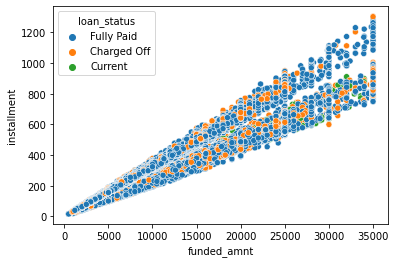

In [342]:
#Checking the relation between funded_amnt and installment with respect to loan_status
sns.scatterplot(x=df1['funded_amnt'],y=df1['installment'],hue=df1['loan_status'])

<AxesSubplot:xlabel='funded_amnt'>

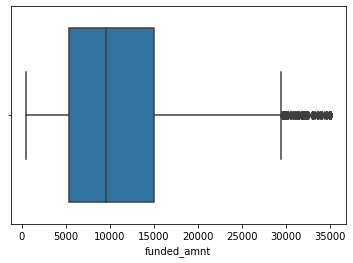

In [343]:
#Checking the boxplot of the funded_amnt
sns.boxplot(x=df1['funded_amnt'])

<AxesSubplot:xlabel='annual_inc', ylabel='loan_status'>

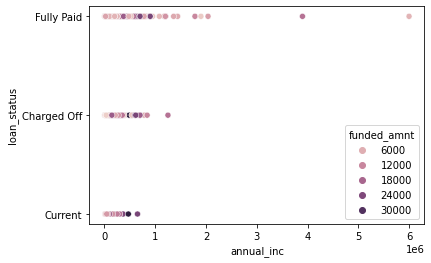

In [344]:
#Check the relationship between loan_status and annual_inc
sns.scatterplot(x=df1['annual_inc'],y=df1['loan_status'],hue=df1['funded_amnt'])

Conclusion of this Relationship between loan_status and annual_inc with respect to funded_amnt:-
    
1.Fully Paid Loan are the one which has almost 6000-18000(average funded amnt) So they were able to pay the loan 

2.Charged Off Loan are the one which has more than 25000-30000(average fund amnt).So as the 
    amount of the funded_amnt is high then they are most probably likely to default(My Opinion)

<AxesSubplot:xlabel='total_rec_prncp', ylabel='total_rec_int'>

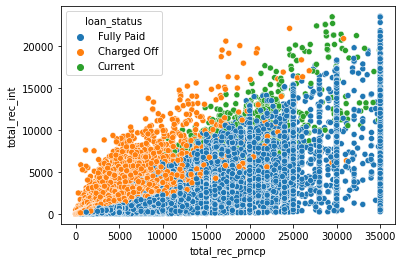

In [345]:
sns.scatterplot(x=df1['total_rec_prncp'],y=df1['total_rec_int'],hue=df1['loan_status'])

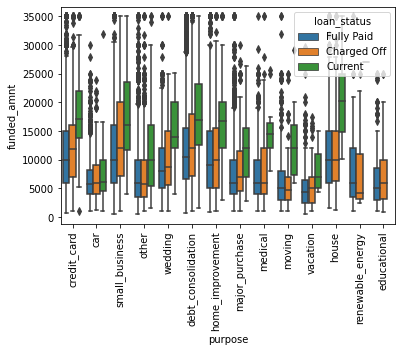

In [346]:
sns.boxplot(x=df1['purpose'],y=df1['funded_amnt'],hue=df1['loan_status'])
plt.xticks(rotation=90)
plt.show()

Conclusion from this Analysis:

The funded_amnt for Charged_Off is higher than Fully Paid

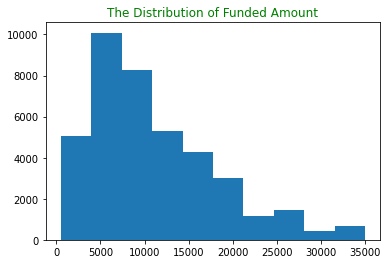

In [347]:
#Checking the Distribution of the Features(some of the columns)
# We can see that some of the columns is skewed 
plt.hist(df1['funded_amnt'])
plt.title('The Distribution of Funded Amount',color='green')
plt.show()

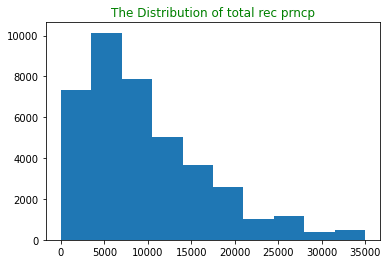

In [348]:
plt.hist(df1['total_rec_prncp'])
plt.title('The Distribution of total rec prncp',color='green')
plt.show()

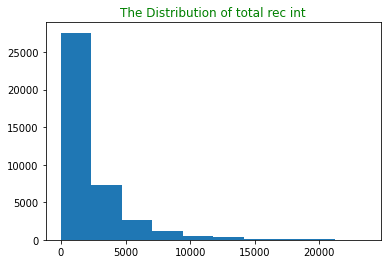

In [349]:
plt.hist(df1['total_rec_int'])
plt.title('The Distribution of total rec int',color='green')
plt.show()

In [350]:
#How to check Outliers using Inter Quartile Range
Q1=df1['funded_amnt'].quantile(0.25)
Q3=df1['funded_amnt'].quantile(0.75)
print('The First Quartile is',Q1)
print('The third Quartile is',Q3)
IQR=Q3-Q1
print('The InterQuartle Range is',IQR)

The First Quartile is 5400.0
The third Quartile is 15000.0
The InterQuartle Range is 9600.0


In [351]:
#Checking lower_whisker and upper whisker
lower_whisker=df1['funded_amnt'].quantile(0.25) - 1.5 *IQR
upper_whisker=df1['funded_amnt'].quantile(0.75) + 1.5 *IQR
print('The lower whisker of the funded amnt is',lower_whisker)
print('The upper whisker of the funded amnt is',upper_whisker)

The lower whisker of the funded amnt is -9000.0
The upper whisker of the funded amnt is 29400.0


In [352]:
#Checking lower_extreme and higher extreme values
lower_extreme=df1['funded_amnt'].quantile(0.25) - 3*df1['funded_amnt'].std()
higher_extreme=df1['funded_amnt'].quantile(0.75) + 3*df1['funded_amnt'].std()
print('The lower extreme of the funded amnt is',lower_extreme)
print('The upper extreme of the funded amnt is',higher_extreme)

The lower extreme of the funded amnt is -16161.716009784286
The upper extreme of the funded amnt is 36561.716009784286


In [353]:
#Checking the value greater than upper_whisker
df1[df1['funded_amnt']>29400].shape

(1038, 43)

# Analysis In Categorical Variables:
    
1.How to Handle Missing Values in Categorical Features

2.How to Check Relation between Categorical Features(Association)

3.How to encode Categorical Features In Machine Learning(Using LabelEncoding)

-There are other approach than LabelEncoding but for this usecase we will use the most simple one

In [354]:
#Checking if it is having missing values
#There is no missing values in categorical variable so we can go ahead in analyzing the categorical
#variable 
df_categorical.isnull().sum()

term                   0
int_rate               0
grade                  0
sub_grade              0
home_ownership         0
verification_status    0
issue_d                0
loan_status            0
pymnt_plan             0
url                    0
purpose                0
zip_code               0
addr_state             0
earliest_cr_line       0
initial_list_status    0
application_type       0
dtype: int64

<AxesSubplot:xlabel='home_ownership', ylabel='int_rate'>

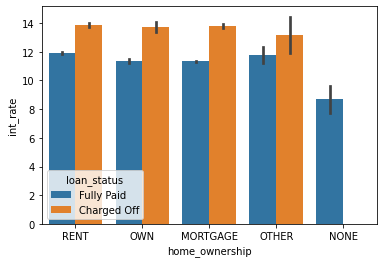

In [355]:
# Checking the relationship between int_rate,home_ownership with respect to loan_status
sns.barplot(x='home_ownership',y='int_rate',hue='loan_status',data=df_categorical)

Conclusion From the Relation:-

Charged Off interest_rate are higher than Full_Paid.This is the opportunity for the Bank
to take higher interest rate and penalty fee(In My Opinion)

Highest Charged Off is For Rented Customers.From this Analysis We can say that there is high
chance that they will default on loan 

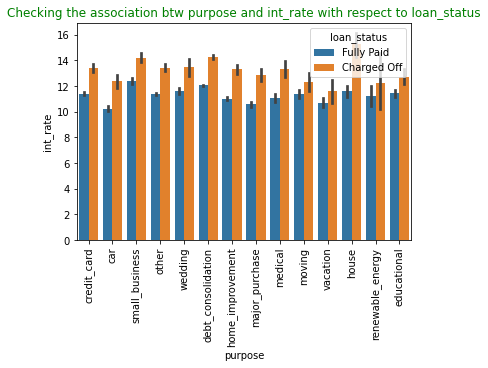

In [356]:
#Checking the relationship between int_rate,loan_status,purpose
sns.barplot(x='purpose',y='int_rate',hue='loan_status',data=df_categorical)
plt.title('Checking the association btw purpose and int_rate with respect to loan_status',color='green')
plt.xticks(rotation=90)
plt.show()

Conclusion From the Analysis:-
    
Highest Charged_Off Are (House,debt_consolidation,small_business,credit_card).So In my opinion
bank should focus on this three to four sector to decrease their losses

<AxesSubplot:xlabel='term', ylabel='int_rate'>

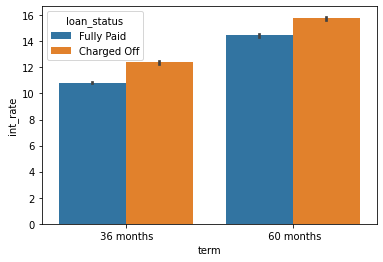

In [357]:
# Checking the association between term,int_rate,loan_status
sns.barplot(x='term',y='int_rate',hue='loan_status',data=df_categorical)

Conclusion from this Analysis:-

Term with 36 months tend to have a lower_interest_rate for Charged_Off than than term of 60 months.

<AxesSubplot:xlabel='term', ylabel='int_rate'>

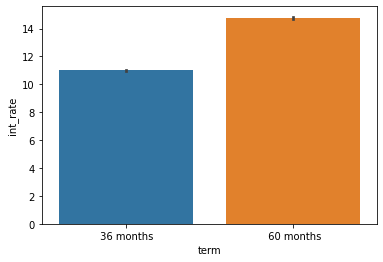

In [358]:
# Checking the association between term and int_rate
sns.barplot(x='term',y='int_rate',data=df_categorical)

Conclusion From this Analysis:-
    
So we are right The interest rate for term of 36 months is lower than 60 months.

<AxesSubplot:xlabel='grade', ylabel='int_rate'>

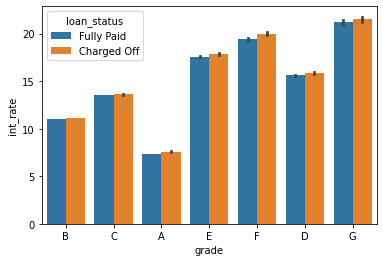

In [359]:
sns.barplot(x='grade',y='int_rate',hue='loan_status',data=df_categorical)

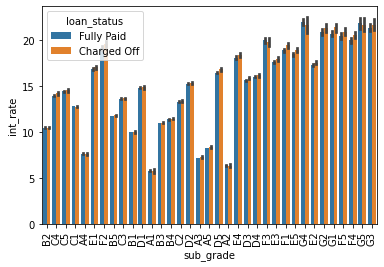

In [360]:
sns.barplot(x='sub_grade',y='int_rate',hue='loan_status',data=df_categorical)
plt.xticks(rotation=90)
plt.show()

In [361]:
  
# This function take a dataframe
# as a parameter and returning list
# of column names whose contents 
# are duplicates.
def getDuplicateColumns(df):
  
    # Create an empty set
    duplicateColumnNames = set()
      
    # Iterate through all the columns 
    # of dataframe
    for x in range(df.shape[1]):
          
        # Take column at xth index.
        col = df.iloc[:, x]
          
        # Iterate through all the columns in
        # DataFrame from (x + 1)th index to
        # last index
        for y in range(x + 1, df.shape[1]):
              
            # Take column at yth index.
            otherCol = df.iloc[:, y]
              
            # Check if two columns at x & y
            # index are equal or not,
            # if equal then adding 
            # to the set
            if col.equals(otherCol):
                duplicateColumnNames.add(df.columns.values[y])
                  
    # Return list of unique column names 
    # whose contents are duplicates.
    return list(duplicateColumnNames)

In [362]:
getDuplicateColumns(df_numeric)

['delinq_amnt']

In [363]:
# Dropping duplicate and irrelevant columns in the data
df_numeric.drop(columns=['loan_amnt','delinq_amnt','id'],axis=1,inplace=True)

C:\Users\asif\Anaconda3\envs\imarticus\lib\site-packages\pandas\core\frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [364]:
#Using LabelEncoder Object
labelencoder=LabelEncoder()

In [365]:
# Dropping some of the features which is not useful in interpreting the loan_status 
df4=df_categorical.copy()
df4.drop(['issue_d','earliest_cr_line','zip_code','url'],axis=1,inplace=True)

In [366]:
# Checking If it is present or not and as per our data preprocessing steps the labels has been removed
df4[df4['loan_status']=='Current']

,term,int_rate,grade,sub_grade,home_ownership,verification_status,loan_status,pymnt_plan,purpose,addr_state,initial_list_status,application_type


In [367]:
#Encoding Categorical Feature(Very Important Step in this UseCases)
df4['addr_state']=labelencoder.fit_transform(df4['addr_state'])
df4['sub_grade']=labelencoder.fit_transform(df4['sub_grade'])
df4['loan_status']=labelencoder.fit_transform(df4['loan_status'])
df4['term']=labelencoder.fit_transform(df4['term'])
df4['home_ownership']=labelencoder.fit_transform(df4['home_ownership'])
df4['verification_status']=labelencoder.fit_transform(df4['verification_status'])
df4['pymnt_plan']=labelencoder.fit_transform(df4['pymnt_plan'])
df4['grade']=labelencoder.fit_transform(df4['grade'])
df4['purpose']=labelencoder.fit_transform(df4['purpose'])
df4['initial_list_status']=labelencoder.fit_transform(df4['initial_list_status'])
df4['application_type']=labelencoder.fit_transform(df4['application_type'])

In [368]:
# Checking If it applied or not
df4.head()

,term,int_rate,grade,sub_grade,home_ownership,verification_status,loan_status,pymnt_plan,purpose,addr_state,initial_list_status,application_type
0,0,10.65,1,6,4,2,1,0,1,3,0,0
1,1,15.27,2,13,4,1,0,0,0,10,0,0
2,0,15.96,2,14,4,0,1,0,11,14,0,0
3,0,13.49,2,10,4,1,1,0,9,4,0,0
5,0,7.90,0,3,4,1,1,0,13,3,0,0


In [369]:
df4['loan_status'].value_counts(ascending=True)

0     5627
1    32950
Name: loan_status, dtype: int64

In [370]:
df_model=pd.concat([df_numeric,df4],axis=1)

In [371]:
df_model.columns

Index(['member_id', 'funded_amnt', 'funded_amnt_inv', 'installment',
       'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc',
       'pub_rec', 'revol_bal', 'total_acc', 'out_prncp', 'out_prncp_inv',
       'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_amnt', 'policy_code', 'acc_now_delinq', 'term', 'int_rate',
       'grade', 'sub_grade', 'home_ownership', 'verification_status',
       'loan_status', 'pymnt_plan', 'purpose', 'addr_state',
       'initial_list_status', 'application_type'],
      dtype='object')

In [372]:
df_model.shape

(39717, 36)

In [373]:
df_model.dropna(axis=0,inplace=True)

In [374]:
df_model.isnull().sum()

member_id                  0
funded_amnt                0
funded_amnt_inv            0
installment                0
annual_inc                 0
dti                        0
delinq_2yrs                0
inq_last_6mths             0
open_acc                   0
pub_rec                    0
revol_bal                  0
total_acc                  0
out_prncp                  0
out_prncp_inv              0
total_pymnt                0
total_pymnt_inv            0
total_rec_prncp            0
total_rec_int              0
total_rec_late_fee         0
recoveries                 0
collection_recovery_fee    0
last_pymnt_amnt            0
policy_code                0
acc_now_delinq             0
term                       0
int_rate                   0
grade                      0
sub_grade                  0
home_ownership             0
verification_status        0
loan_status                0
pymnt_plan                 0
purpose                    0
addr_state                 0
initial_list_s

In [375]:
X=df_model.drop('loan_status',axis=1)
y=df_model['loan_status']

In [376]:
# using imblearn(under Sampling)
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
#Split train-test data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20,random_state=1)

# summarize class distribution
print("Before undersampling: ", Counter(y_train))

# define undersampling strategy
undersample = RandomUnderSampler(sampling_strategy='majority')

# fit and apply the transform
X_train_under, y_train_under = undersample.fit_resample(X_train, y_train)

# summarize class distribution
print("After undersampling: ", Counter(y_train_under))

#PART 2
# import SVM libraries 
from sklearn.svm import SVC
from sklearn.metrics import classification_report, roc_auc_score

model=SVC()
clf_under = model.fit(X_train_under, y_train_under)
pred_under = clf_under.predict(X_test)

print("ROC AUC score for undersampled data: ", roc_auc_score(y_test, pred_under))

Before undersampling:  Counter({1.0: 26343, 0.0: 4518})
After undersampling:  Counter({0.0: 4518, 1.0: 4518})
ROC AUC score for undersampled data:  0.7399382271146416


In [377]:
# OverSampling
from imblearn.over_sampling import SMOTE

In [ ]:
# summarize class distribution
from imblearn.over_sampling import SMOTE
print("Before oversampling: ",Counter(y_train))

# define oversampling strategy
SMOTE = SMOTE()

# fit and apply the transform
X_train_SMOTE, y_train_SMOTE = SMOTE.fit_resample(X_train, y_train)

# summarize class distribution
print("After oversampling: ",Counter(y_train_SMOTE))

#PART 2
# import SVM libraries 
from sklearn.svm import SVC
from sklearn.metrics import classification_report, roc_auc_score

model=SVC()
clf_SMOTE = model.fit(X_train_SMOTE, y_train_SMOTE)
pred_SMOTE = clf_SMOTE.predict(X_test)

print("ROC AUC score for oversampled SMOTE data: ", roc_auc_score(y_test, pred_SMOTE))

Before oversampling:  Counter({1.0: 26343, 0.0: 4518})
After oversampling:  Counter({1.0: 26343, 0.0: 26343})


In [ ]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
# define pipeline
model = SVC()
over = SMOTE(sampling_strategy=0.4,random_state=1)
under = RandomUnderSampler(sampling_strategy=0.5,random_state=1)
steps = [('o', over), ('u', under), ('model', model)]
pipeline = Pipeline(steps=steps)

#PART 2
# import libraries for evaluation
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from numpy import mean

# evaluate pipeline
scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=5, n_jobs=-1)
score = mean(scores)
print('ROC AUC score for the combined sampling method: %.3f' % score)

In [ ]:
###### from sklearn.pipeline import Pipeline
#from sklearn.neighbors import KNeighborsClassifier
#over = SMOTE()
#under = RandomUnderSampler()
#steps = [('over', over), ('under', under),('knn',KNeighborsClassifier()),
                              # ('decisiontree',DecisionTreeClassifier()),('rf',RandomForestClassifier())]
#pipeline_decision=Pipeline(steps=steps)
#pipeline_decision.fit(X_train,y_train)

In [ ]:
from imblearn.over_sampling import SMOTE
model_decision=DecisionTreeClassifier()
over_decision=SMOTE(sampling_strategy=0.4,random_state=1)
under_decision=RandomUnderSampler(sampling_strategy=0.5,random_state=1)
steps=[('o',over_decision),('u',under_decision),('model',model_decision)]
pipeline_decision=Pipeline(steps=steps)
scores_d=cross_val_score(pipeline_decision,X_train,y_train,scoring='roc_auc',cv=5,n_jobs=-1)
score_decision=mean(scores_d)
print('ROC AUC score for the combined sampling method: %.3f' % score_decision)

# How do I know which sampling ratio is the best?

In the tutorial above, we either under- or/and oversample the data to have a balanced 50:50 distribution of both classes. But what if we want to find out the best sampling ratio based on the model performance? We can do this by implementing a for loops in Python to iterate a possible list of sampling ratio and see which combination has the best performance based on the mean ROC AUC score (or other performance metrics of choice) after cross-validation.

The code snippet shows you the codes to create a pipeline to resample the data using both under- and oversampling method. The list of possible ratios for oversampling is [0.3,0.4,0.5] while for undersampling [0.7,0.6,0.5]. These ratios are selected randomly for demonstration purposes and can be replaced with other values after some trial and error. The Support Vector Machine is then trained with the resampled data for every possible pair of the ratios combination before outputting the mean ROC AUC score after cross-validation.

In [ ]:
# values to evaluate
#over_values = [0.3,0.4,0.5]
#under_values = [0.7,0.6,0.5]
#for o in over_values:
#    for u in under_values:
#        # define pipeline
#        model = SVC()
#        over = SMOTE(sampling_strategy=o)
#        under = RandomUnderSampler(sampling_strategy=u)
#        steps = [('over', over), ('under', under), ('model', model)]
#        pipeline = Pipeline(steps=steps)
#        # evaluate pipeline
#        scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=5, n_jobs=-1)
#        score = mean(scores)
#        print('SMOTE oversampling rate:%.1f, Random undersampling rate:%.1f , Mean ROC AUC: %.3f' % (o, u, score))


In [ ]:
print('The shape of the X_train and y_train is:',X_train.shape,y_train.shape)
print('The shape of the X_test and y_test is:',X_test.shape,y_test.shape)

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
over_rf=SMOTE(sampling_strategy=0.4,random_state=1)
#under_rf=RandomUnderSampler()
steps=[('o',over_rf),('model',RandomForestClassifier(random_state=1))]
#pipeline_rf=Pipeline(steps=steps)

In [ ]:
from sklearn.metrics import accuracy_score,confusion_matrix,roc_auc_score,auc,classification_report
class Model_Building_Pipelines:
    def __init__(self,Pipeline):
        over_rf=SMOTE(sampling_strategy=0.4,random_state=1)
        steps=[('o',over_rf),('model',RandomForestClassifier(random_state=1))]
        print('----Building Pipelines----')
        print()
        self.Pipeline=Pipeline
    def fit_data(self,features,targets):
        print()
        print('----Fitting the Data to the Model')
        Pipeline=self.Pipeline.fit(features,targets)
        return Pipeline
    
    def predict_data(self,data):
        print()
        self.y_pred=self.Pipeline.predict(data)
    def result_training_data(self,y_true,y_pred):
        print()
        print('-----RESULT OF TRAINING DATA-----')
        print()
        print('-----Accuracy score for Training Data-----')
        accuracy_score_train=accuracy_score(y_true,self.Pipeline.predict(y_pred))
        print(accuracy_score_train)
        print()
        print('-----Confusion Matrix for Training Data-----')
        print()
        confusion_matrix_train=confusion_matrix(y_true,self.Pipeline.predict(y_pred))
        print(confusion_matrix_train)
        print()
        print('-----Classification Report of Training Data-----')
        classification_report_train=classification_report(y_true,self.Pipeline.predict(y_pred))
        print(classification_report_train)
        print()
        print('-----roc_auc_score of Training Data------')
        roc_auc_score_train=roc_auc_score(y_true,self.Pipeline.predict(y_pred))
        print(roc_auc_score_train)
        print()
    def result_testing_data(self,y_true,y_pred):
        print('-----RESULT OF TESTING DATA-----')
        print('-----Accuracy score for Testing Data-----')
        accuracy_score_test=accuracy_score(y_true,self.y_pred)
        print(accuracy_score_test)
        print()
        print('-----Confusion Matrix for Testing Data-----')
        confusion_matrix_test=confusion_matrix(y_true,self.y_pred)
        print(confusion_matrix_test)
        print()
        print('-----Classification Report of Testing Data-----')
        classification_report_test=classification_report(y_true,self.y_pred)
        print(classification_report_test)
        print()
        print('-----roc_auc_score of Testing Data------')
        roc_auc_score_test=roc_auc_score(y_true,self.y_pred)
        print(roc_auc_score_test)
        
    def predict_probability(self,data):
        print('--Predicting the Probability of the Model')
        probability=self.Pipeline.predict_proba(data)
        return probability

In [ ]:
Pipeline_rf1=Model_Building_Pipelines(Pipeline(steps=steps))
Pipeline_rf1.fit_data(X_train,y_train)
y_pred_pipeline=Pipeline_rf1.predict_data(X_test)
Pipeline_rf1.result_training_data(y_train,X_train)
Pipeline_rf1.result_testing_data(y_test,y_pred_pipeline)

In [ ]:
#Old Code
#pipeline_rf.fit(X_train,y_train)

In [ ]:
#Old Code
#y_pred=pipeline_rf.predict(X_test)

In [ ]:
class Tuning_Pipelines:
    def __init__(self,Pipeline):
        self.Pipeline=Pipeline
    def params(self,param_grid):
        self.param_grid=param_grid
        return self.param_grid
    def fit_data_1(self,features,targets):
        self.Pipeline=GridSearchCV(self.Pipeline,param_grid=self.param_grid,scoring='f1',cv=5,n_jobs=-1)
        self.Pipeline=self.Pipeline.fit(features,targets)
        return self.Pipeline
    def predict_data_1(self,data):
        y_pred=self.Pipeline.predict(data)
    
    def result_training_data_1(self,y_true,y_pred):
        print()
        print('-----RESULT OF TRAINING DATA-----')
        print()
        print('-----Accuracy score for Training Data-----')
        accuracy_score_train=accuracy_score(y_true,self.Pipeline.predict(y_pred))
        print(accuracy_score_train)
        print()
        print('-----Confusion Matrix for Training Data-----')
        print()
        confusion_matrix_train=confusion_matrix(y_true,self.Pipeline.predict(y_pred))
        print(confusion_matrix_train)
        print()
        print('-----Classification Report of Training Data-----')
        classification_report_train=classification_report(y_true,self.Pipeline.predict(y_pred))
        print(classification_report_train)
        print()
        print('-----roc_auc_score of Training Data------')
        roc_auc_score_train=roc_auc_score(y_true,self.Pipeline.predict(y_pred))
        print(roc_auc_score_train)
        print()
    def result_testing_data_1(self,y_true,y_pred):
        print('-----RESULT OF TESTING DATA-----')
        print('-----Accuracy score for Testing Data-----')
        accuracy_score_test=accuracy_score(y_true,y_pred)
        print(accuracy_score_test)
        print()
        print('-----Confusion Matrix for Testing Data-----')
        confusion_matrix_test=confusion_matrix(y_true,y_pred)
        print(confusion_matrix_test)
        print()
        print('-----Classification Report of Testing Data-----')
        classification_report_test=classification_report(y_true,y_pred)
        print(classification_report_test)
        print()
        print('-----roc_auc_score of Testing Data------')
        roc_auc_score_test=roc_auc_score(y_true,y_pred)
        print(roc_auc_score_test)
        
    def predict_probability_1(self,data):
        print('--Predicting the Probability of the Model')
        probability=self.Pipeline.predict_proba(data)
        return probability

In [ ]:
class Model_Tuning:
    def __init__(self,Model):
        print('-----BUILDING THE MODEL-----')
        self.Model=Model
    
    def params(self,param_grid):
        print('----SETTING THE PARAMS-------')
        self.param_grid=param_grid
        return self.param_grid

    def fit_data(self,features,targets):
        print('----FITTING THE MODEL-----')
        self.Model=GridSearchCV(self.Model,param_grid=self.param_grid,scoring='f1',cv=5,verbose=3,n_jobs=-1)
        self.Model=self.Model.fit(features,targets)
        return self.Model
    
    def predict_data(self,data):
        print('----PREDICTING THE MODEL----')
        self.y_pred=self.Model.predict(data)
    
    def result_training_data(self,y_true,y_pred):
        print()
        print('-----RESULT OF TRAINING DATA-----')
        print()
        print('-----Accuracy score for Training Data-----')
        accuracy_score_train=accuracy_score(y_true,self.Model.predict(y_pred))
        print(accuracy_score_train)
        print()
        print('-----Confusion Matrix for Training Data-----')
        print()
        confusion_matrix_train=confusion_matrix(y_true,self.Model.predict(y_pred))
        print(confusion_matrix_train)
        print()
        print('-----Classification Report of Training Data-----')
        classification_report_train=classification_report(y_true,self.Model.predict(y_pred))
        print(classification_report_train)
        print()
        print('-----roc_auc_score of Training Data------')
        roc_auc_score_train=roc_auc_score(y_true,self.Model.predict(y_pred))
        print(roc_auc_score_train)
        print()
    def result_testing_data(self,y_true,y_pred):
        print('-----RESULT OF TESTING DATA-----')
        print('-----Accuracy score for Testing Data-----')
        accuracy_score_test=accuracy_score(y_true,self.y_pred)
        print(accuracy_score_test)
        print()
        print('-----Confusion Matrix for Testing Data-----')
        confusion_matrix_test=confusion_matrix(y_true,self.y_pred)
        print(confusion_matrix_test)
        print()
        print('-----Classification Report of Testing Data-----')
        classification_report_test=classification_report(y_true,self.y_pred)
        print(classification_report_test)
        print()
        print('-----roc_auc_score of Testing Data------')
        roc_auc_score_test=roc_auc_score(y_true,self.y_pred)
        print(roc_auc_score_test)
        
    def predict_probability(self,data):
        print('--Predicting the Probability of the Model')
        probability=self.Model.predict_proba(data)
        return probability

In [ ]:
clf_decision=Model_Tuning(DecisionTreeClassifier())
clf_decision.params(param_grid={
    'max_depth':np.arange(2,7,1),
    'ccp_alpha':np.arange(0.1,1,0.1)
})
clf_decision.fit_data(X_train,y_train)
y_pred=clf_decision.predict_data(X_test)
clf_decision.result_training_data(y_train,X_train)
clf_decision.result_testing_data(y_test,y_pred)

In [ ]:
clf_decision.fit_data(X_train,y_train)

In [ ]:
Pipeline_grid=Tuning_Pipelines(Pipeline(steps=steps))
Pipeline_grid.params(param_grid={
    'Pipeline_grid__max_depth':np.arange(2,7,1),
    'Pipeline_grid__ccp_alpha':np.arange(0.1,1,0.1)})

In [ ]:
#Pipeline_grid.fit_data_1(X_train,y_train)

In [ ]:
#y_pred=Pipeline_grid.predict_data_1(X_test)
#Pipeline_grid.result_training_data_1(y_train,X_train)
#Pipeline_grid.result_testing_data_1(y_test,y_pred)

In [ ]:
###Now we are tuning the RandomForestModel(old code)
#from sklearn.ensemble import RandomForestClassifier
#param_grid=({
#   'model__max_depth':np.arange(2,5,1),
#    'model__ccp_alpha':np.arange(0,1,0.1)
#})

In [ ]:
#from sklearn.model_selection import GridSearchCV
#from sklearn.pipeline import Pipeline
#pipeline_rf_grid=GridSearchCV(pipeline_rf,param_grid=param_grid,scoring='roc_auc',cv=5,
                              #verbose=3,n_jobs=-1)

In [ ]:
#pipeline_rf_grid.fit(X_train,y_train)

In [ ]:
print(pipeline_rf_grid.best_params_)

In [ ]:
y_pred_grid=pipeline_rf_grid.predict(X_test)

In [ ]:
def metrics_results_gridsearch():
    accuracy_score_train=metrics.accuracy_score(y_train,pipeline_rf_grid.predict(X_train))
    print(accuracy_score_train)
    accuracy_score_test=metrics.accuracy_score(y_test,y_pred_grid)
    print(accuracy_score_test)
    classification_report_train=metrics.classification_report(y_train,pipeline_rf_grid.predict(X_train))
    print(classification_report_train)
    classification_report_test=metrics.classification_report(y_test,y_pred_grid)
    print(classification_report_test)
    confusion_matrix_train=metrics.confusion_matrix(y_train,pipeline_rf_grid.predict(X_train))
    print(confusion_matrix_train)
    confusion_matrix_test=metrics.confusion_matrix(y_test,y_pred_grid)
    print(confusion_matrix_test)
    roc_auc_score_train=metrics.roc_auc_score(y_train,pipeline_rf_grid.predict(X_train))
    print(roc_auc_score_train)
    roc_auc_score_test=metrics.roc_auc_score(y_test,y_pred_grid)
    print(roc_auc_score_test)

In [ ]:
metrics_results_gridsearch()

In [ ]:
from imblearn.pipeline import Pipeline
under_rf=RandomUnderSampler(sampling_strategy=0.5)
steps=[('under_rf',under_rf),('model_rf',RandomForestClassifier(random_state=1))]
pipeline_under=Pipeline(steps=steps)
pipeline_under.fit(X_train,y_train)
y_pred_un=pipeline_under.predict(X_test)

In [ ]:
y_pred_un

In [ ]:
from sklearn.metrics import confusion_matrix
def metrics_result_undersampling():
    confusion_matrix_train=confusion_matrix(y_train,pipeline_under.predict(X_train))
    print('-------------CONFUSION MATRIX FOR TRAIN DATASET----------------')
    print(confusion_matrix_train)
    print('-------------CONFUSION MATRIX FOR TESTING DATASET--------------')
    confusion_matrix_test=confusion_matrix(y_test,y_pred_un)
    print(confusion_matrix_test)
    classification_report_train=metrics.classification_report(y_train,pipeline_under.predict(X_train))
    print(classification_report_train)
    classification_report_test=metrics.classification_report(y_test,y_pred_un)
    print(classification_report_test)
    roc_auc_score_train=metrics.roc_auc_score(y_train,pipeline_under.predict(X_train))
    print(roc_auc_score_train)
    roc_auc_score_test=metrics.roc_auc_score(y_test,y_pred_un)
    print(roc_auc_score_test)

In [ ]:
metrics_result_undersampling()

In [ ]:
"""Now HyperParameter Tuning the Model"""
param_grid=({
    'model_rf__max_depth':np.arange(1,5,2),
    'model_rf__min_samples_split':np.arange(0,1,0.1)
})

In [ ]:
pipeline_under_grid=GridSearchCV(pipeline_under,param_grid=param_grid,scoring='roc_auc',cv=5,verbose=5)
pipeline_under_grid.fit(X_train,y_train)

In [ ]:
y_pred_un_grid=pipeline_under_grid.predict(X_test)
y_pred_un_grid

In [ ]:
def metrics_under_gridsearch():
    confusion_matrix_train=confusion_matrix(y_train,pipeline_under_grid.predict(X_train))
    print('-------------CONFUSION MATRIX FOR TRAIN DATASET----------------')
    print(confusion_matrix_train)
    print('-------------CONFUSION MATRIX FOR TESTING DATASET--------------')
    confusion_matrix_test=confusion_matrix(y_test,y_pred_un_grid)
    print(confusion_matrix_test)
    classification_report_train=metrics.classification_report(y_train,pipeline_under_grid.predict(X_train))
    print(classification_report_train)
    classification_report_test=metrics.classification_report(y_test,y_pred_un_grid)
    print(classification_report_test)
    roc_auc_score_train=metrics.roc_auc_score(y_train,pipeline_under_grid.predict(X_train))
    print(roc_auc_score_train)
    roc_auc_score_test=metrics.roc_auc_score(y_test,y_pred_un_grid)
    print(roc_auc_score_test)

In [ ]:
metrics_under_gridsearch()

# How to Save and Load ML Models

WHAT On various instances, while working on developing a Machine Learning Model, we'll need to save our prediction models to file, and then restore them in order to reuse our previous work to.

WHY We need to save and restore/reload later our ML Model , so as to -

a) test our model on/with new data,

b) compare multiple models,

c) or anything else.

object serialization This process / procedure of saving a ML Model is also known as object serialization - representing an object with a stream of bytes, in order to store it on disk, send it over a network or save to a database.

deserialization While the restoring/reloading of ML Model procedure is known as deserialization.

In this we will explore 3 ways to Save and Reload ML Models in Python and scikit-learn, we will also discuss about the pros and cons of each method.


We will be covering following 3 approaches of Saving and Reloading a ML Model -

1) Pickle Approach

2) Joblib Approach

3) Manual Save and Restore to JSON approach

Now , lets develop a ML Model which we shall use to Save and Reload in this Kernel

Approach 1 : Pickle approach

Following lines of code, the Pickled_Model which we created in the previous step is saved to file, and then loaded as a new object called Pickled_Model.

The loaded model is then used to calculate the accuracy score and predict outcomes on new unseen (test) data.

In [ ]:
# Save the Modle to file in the current working directory
import pickle
PKL_Filename='filemodel.pkl'
with open(PKL_Filename,'wb') as file:
    pickle.dump(pipeline_rf,file)

In [ ]:
# Load the Model back from file
with open('filemodel.pkl','rb') as file:
    Pickled_Model=pickle.load(file)

In [ ]:
Pickled_Model

In [ ]:
# Use the Reloaded Model to 
# Calculate the accuracy score and predict target values

# Calculate the Score 
score_1=Pickled_Model.score(X_train,y_train)
score_2 = Pickled_Model.score(X_test, y_test)  
# Print the Score
print("Train Score:{0:.2f} %".format(100 * score_1))
print("Test score: {0:.2f} %".format(100 * score_2))  

# Predict the Labels using the reloaded Model
Ypredict = Pickled_Model.predict(X_test)  

Ypredict

Let's Reflect back on Pickle approach :

PROs of Pickle :

1) save and restore our learning models is quick - we can do it in two lines of code.

2) It is useful if you have optimized the model's parameters on the training data, so you don't need to repeat this step again.

CONs of Pickle :

1) it doesn't save the test results or any data.

Approach 2 - Joblib :

The Joblib Module is available from Scikit Learn package and is intended to be a replacement for Pickle, for objects containing large data.

This approach will save our ML Model in the pickle format only but we dont need to load additional libraries as the 'Pickling' facility is available within Scikit Learn package itself which we will use invariably for developing our ML models.

In following Python scripts , we will show how to Saev and reload ML Models using Joblib

In [ ]:
import joblib

In [ ]:
#Dumping the model using joblib in the current directory
joblib_filename='joblib_Model.pkl'
Joblib_Model=joblib.dump(pipeline_rf,joblib_filename)

In [ ]:
# Loading the model in the current directory
Joblib_Model_load=joblib.load(joblib_filename)

In [ ]:
Joblib_Model_load

In [ ]:
#Checking accuracy score

Joblib_Model_train=Joblib_Model_load.score(X_train,y_train)
Joblib_Model_test=Joblib_Model_load.score(X_test,y_test)
# Print the Score
print("Train Score:{0:.2f} %".format(100 * Joblib_Model_train))
print("Test score: {0:.2f} %".format(100 * Joblib_Model_test))  

# Predict the Labels using the reloaded Model
Ypredict = Joblib_Model_load.predict(X_test)  

Ypredict

Let's Reflect back on Joblib approach :

PROs of Joblib :

1) the Joblib library offers a bit simpler workflow compared to Pickle.

2) While Pickle requires a file object to be passed as an argument, Joblib works with both file objects and string filenames.

3) In case our model contains large arrays of data, each array will be stored in a separate file, but the save and restore procedure will remain the same.

4) Joblib also allows different compression methods, such as 'zlib', 'gzip', 'bz2', and different levels of compression.